In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
import pickle

In [2]:
manual_metrics_dict = {
    'facebook_nips.tsv': {'Average Path Length': 3.980, 'Pseudo Diameter': 9},
    'hamster.tsv': {'Average Path Length': 3.421, 'Pseudo Diameter': 14},
    'brightkite': {'Average Path Length': 4.859, 'Pseudo Diameter': 18},
    'livemocha': {'Average Path Length': 6.188, 'Pseudo Diameter': 6},
    'Twitter': {'Average Path Length': 6.188, 'Pseudo Diameter': 8},
    'youtube': {'Average Path Length': 5.434 , 'Pseudo Diameter': 24},
    'out.contact': {'Average Path Length':2.415 , 'Pseudo Diameter':4 },
    'cond_mat': {'Average Path Length':5.911 , 'Pseudo Diameter':16 },
    'out.com_dblp': {'Average Path Length':6.752 , 'Pseudo Diameter':23 },
    'out.ca_AstroPh': {'Average Path Length':4.174 , 'Pseudo Diameter':14 }
}

In [3]:
def load_data(file_path, delimiter, nrows=None):
    """ Load the data from a file """
    try:
        data = pd.read_csv(file_path, delimiter=delimiter, header=None, names=['source', 'target'], comment='%', nrows=nrows)
        print(f"Data loaded successfully from {file_path}.")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def create_graph(data):
    """ Create a graph from the dataframe """
    if data is not None and not data.empty:
        G = nx.from_pandas_edgelist(data, 'source', 'target')
        return G
    else:
        print("Data is empty or None. Cannot create graph.")
        return None

In [4]:
def calculate_degree_distribution(G):
    degree = np.array(list(dict(nx.degree(G)).values()))
    k, n_k = np.unique(degree, return_counts=True)
    p_k = n_k / len(G)
    return k, p_k, degree

In [ ]:

# def plot_degree_distribution(k, p_k, Kmax, mu, sigma):
#     plt.figure(figsize=(10, 6))

#     # IDP intervals
#     intervals = [
#         (1, mu-sigma),
#         (mu-sigma, mu),
#         (mu, mu+sigma),
#         (mu+sigma, Kmax)
#     ]
#     interval_names = ['IDP1', 'IDP2', 'IDP3', 'IDP4']
#     colors = ['b', 'g', 'r', 'c']

#     for (i, ((start, end), name, color)) in enumerate(zip(intervals, interval_names, colors)):
#         mask = (k >= start) & (k <= end)
#         plt.plot(k[mask], p_k[mask], 'o', markersize=8, label=f'{name} ({start:.2f}, {end:.2f})', color=color)

#     plt.yscale('log')
#     plt.xscale('log')

#     plt.xlabel('Degree (k)', fontsize=14)
#     plt.ylabel('Probability (P(k))', fontsize=14)
#     plt.title('Degree Distribution on a Log-Log Scale', fontsize=16)

#     plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.legend(fontsize=12)
#     plt.tight_layout()
#     plt.show()

In [ ]:
# def draw_subgraph(G, num_nodes=50, node_color='red', node_size=50):
#     """ Draw a subgraph with a specified number of nodes """
#     subgraph_nodes = list(G.nodes())[:num_nodes]
#     subgraph = G.subgraph(subgraph_nodes)
#     nx.draw(subgraph, with_labels=True, node_color=node_color, node_size=node_size)
#     plt.show()

In [18]:
from MLE_functions import *

In [5]:
def calculate_remaining_metrics(G, k, p_k, Kmax, mu, sigma, file_path):
    # Calculate the metrics
    metrics = {}

    metrics['Assortativity'] = nx.degree_assortativity_coefficient(G)
    metrics['Average Clustering Coefficient'] = nx.average_clustering(G)  
    metrics['Global Clustering Coefficient'] = nx.transitivity(G)
    metrics['Density'] = nx.density(G)
    metrics['Maximum Degree'] = np.max(k)

    # Calculate max degree centrality
    degree_centrality = nx.degree_centrality(G)
    max_degree_centrality = max(degree_centrality.values())
    metrics['Max Degree Centrality'] = max_degree_centrality

    # Calculate max eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
    max_eigenvector_centrality = max(eigenvector_centrality.values())
    metrics['Max Eigenvector Centrality'] = max_eigenvector_centrality 

    # Use manually provided values for Average Path Length and Pseudo Diameter
    manual_metrics = manual_metrics_dict.get(file_path, {})
    metrics['Pseudo Diameter'] = manual_metrics.get('Pseudo Diameter')
    metrics['Average Path Length'] = manual_metrics.get('Average Path Length')

    # Calculate MLE for degree distribution
    result = [0]*6
    result[1] = 'Trunc_PL'
    mle_params = opt_single_dist(np.array(list(dict(G.degree()).values())), result, 1)
    for idx, param in enumerate(mle_params):
        metrics[f'MLE Parameter {idx+1}'] = param

    print(f"\nMetrics for {file_path}:")
    for key, value in metrics.items():
        print(f"{key}: {value}")

    return metrics

In [6]:
def analyze_dataset(file_path, delimiter, nrows=None):
    data = load_data(file_path, delimiter, nrows)
    G = create_graph(data)

    if G is not None:
        k, p_k, degree = calculate_degree_distribution(G)
        Kmax = np.max(degree)
        mu = np.mean(degree)
        sigma = np.std(degree)

    # Calculate and print network metrics
        metrics = calculate_remaining_metrics(G, k, p_k, Kmax, mu, sigma, file_path)

    return metrics

In [13]:
from sklearn.preprocessing import scale
import numpy as np

In [19]:
def main():
    datasets = [
        ('facebook_nips.tsv', ' '),
        ('hamster.tsv', '\t'),
        ('brightkite', ' '),
        ('livemocha', ' '),
        ('Twitter', ' '),
        ('youtube', ' '),
        ('out.contact', ' '),
        ('cond_mat', ' '),
        ('out.com_dblp', ' '),
        ('out.ca_AstroPh', ' ')
    ]

    all_metrics = []
    for file_path, delimiter in datasets:
        print(f"\nProcessing dataset: {file_path}")
        metrics = analyze_dataset(file_path, delimiter)
        all_metrics.append(metrics)

    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(all_metrics)

    # Scale the data
    scaled_data = scale(metrics_df)

    # Save the standardized metrics to a file
    with open('metrics_scaled.pkl', 'wb') as f:
        pickle.dump(scaled_data, f)

if __name__ == "__main__":
    main()



Processing dataset: facebook_nips.tsv
Data loaded successfully from facebook_nips.tsv.

Metrics for facebook_nips.tsv:
Assortativity: -0.6682140067239859
Average Clustering Coefficient: 0.027247421431211827
Global Clustering Coefficient: 0.0003593802862141459
Density: 0.0007150690793671507
Maximum Degree: 769
Max Degree Centrality: 0.2663664703844822
Max Eigenvector Centrality: 0.7024818331273989
Pseudo Diameter: 9
Average Path Length: 3.98
MLE Parameter 1: 22.064404432132964
MLE Parameter 2: 4.0

Processing dataset: hamster.tsv
Data loaded successfully from hamster.tsv.

Metrics for hamster.tsv:
Assortativity: 0.04740391079367799
Average Clustering Coefficient: 0.5376264832943294
Global Clustering Coefficient: 0.23143166252210473
Density: 0.005653870016403056
Maximum Degree: 273
Max Degree Centrality: 0.11257731958762887
Max Eigenvector Centrality: 0.21147750381814578
Pseudo Diameter: 14
Average Path Length: 3.421
MLE Parameter 1: 24.80621836628208
MLE Parameter 2: 0.5618704103720661

C:\Users\Aadesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\algorithms\assortativity\correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)



Metrics for cond_mat:
Assortativity: nan
Average Clustering Coefficient: 0.0
Global Clustering Coefficient: 0
Density: 4.16567731830357e-06
Maximum Degree: 1
Max Degree Centrality: 4.16567731830357e-06
Max Eigenvector Centrality: 0.12556961014322868
Pseudo Diameter: 16
Average Path Length: 5.911
MLE Parameter 1: 1.0000019298271272
MLE Parameter 2: 1.0

Processing dataset: out.com_dblp
Data loaded successfully from out.com_dblp.

Metrics for out.com_dblp:
Assortativity: 0.2665208308659543
Average Clustering Coefficient: 0.6324308280637565
Global Clustering Coefficient: 0.3063766130023435
Density: 2.08846661642591e-05
Maximum Degree: 343
Max Degree Centrality: 0.001081749343223613
Max Eigenvector Centrality: 0.10083201872350248
Pseudo Diameter: 23
Average Path Length: 6.752
MLE Parameter 1: 9.8991130854225
MLE Parameter 2: 0.5000000000000002

Processing dataset: out.ca_AstroPh
Data loaded successfully from out.ca_AstroPh.

Metrics for out.ca_AstroPh:
Assortativity: 0.2051294310342052
Av

In [23]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load standardized metrics
with open('metrics_scaled.pkl', 'rb') as f:
    scaled_data = pickle.load(f)

datasets = [
    'facebook_nips.tsv': 'Social Network',
    'hamster.tsv',
    'brightkite',
    'livemocha',
    'Twitter',
    'youtube',
    'out.contact',
    'cond_mat',
    'out.com_dblp',
    'out.ca_AstroPh'
]

In [26]:
import numpy as np

# Replace NaN with the mean of each column
mean_values = np.nanmean(scaled_data, axis=0)
indices = np.where(np.isnan(scaled_data))
scaled_data[indices] = np.take(mean_values, indices[1])

In [27]:
print(scaled_data)

[[-9.87900816e-01 -6.45235916e-01 -7.44589894e-01 -3.34868070e-01
   5.10627429e-01  3.99875444e-01  1.19912507e+00 -7.06106394e-01
  -7.14054697e-01  7.27317929e-02  1.37070555e+00]
 [ 6.86187131e-01  1.26076066e+00  1.04179287e+00  1.23719175e+00
  -7.01196517e-01 -1.22303372e-01 -6.29549826e-01  6.14005560e-02
  -1.13324875e+00  3.55739312e-01 -1.05623021e+00]
 [ 6.00594358e-01 -1.03444224e-01  1.07406739e-01 -5.22283307e-01
   1.40239303e+00 -4.38423185e-01 -8.50918837e-01  6.75406116e-01
  -5.48926736e-02  6.18625554e-01 -6.20992753e-01]
 [ 2.53964650e-02 -7.46990663e-01 -7.47368205e-01 -5.62215704e-01
   1.64915557e+00 -5.02725270e-01  1.21635003e+00 -1.16661056e+00
   9.41724311e-01  5.67288261e-02  9.54473736e-01]
 [ 3.66885936e-01 -7.46990663e-01 -7.47368205e-01 -5.62165719e-01
  -8.81992832e-01 -5.04030862e-01  1.21635003e+00 -8.59607784e-01
   9.41724311e-01 -7.77048178e-03  9.66637009e-01]
 [-1.76406770e+00 -7.46990663e-01 -7.47368205e-01  2.55818634e+00
  -8.72220058e-01  

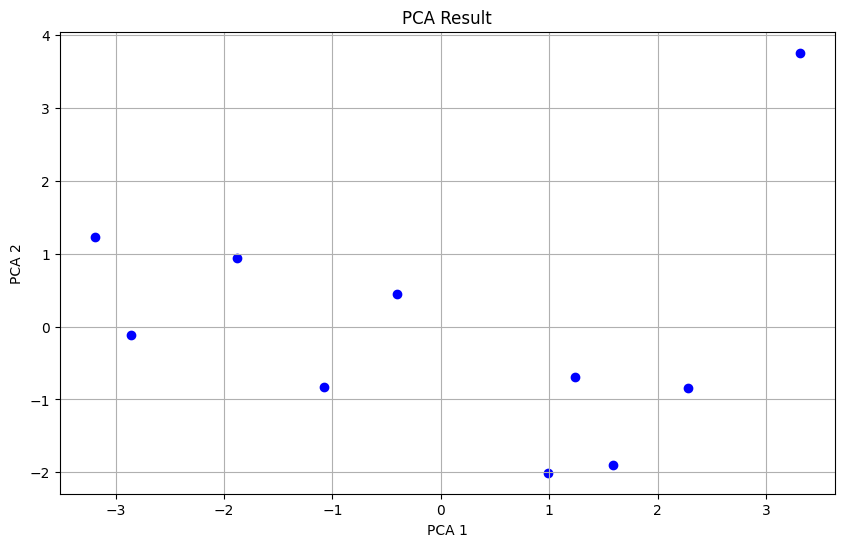

In [28]:
# Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Plot PCA result
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', marker='o')
plt.title('PCA Result')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

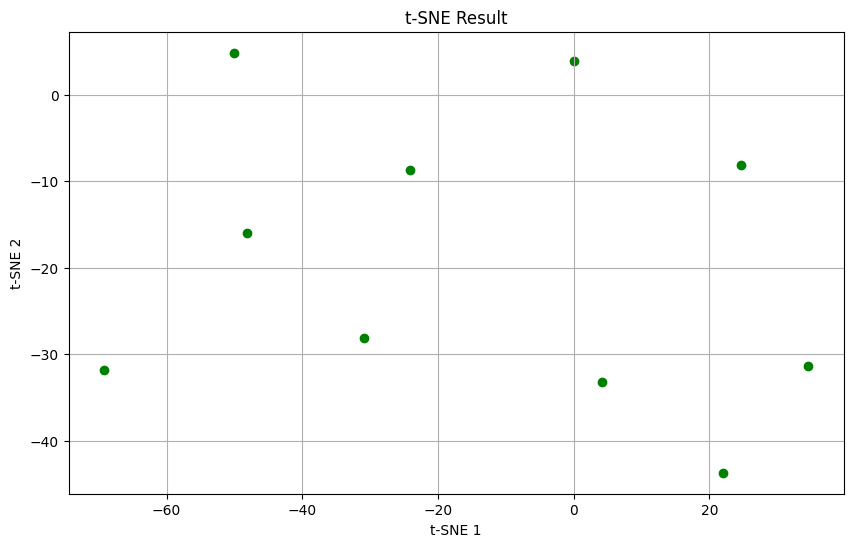

C:\Users\Aadesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\Aadesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


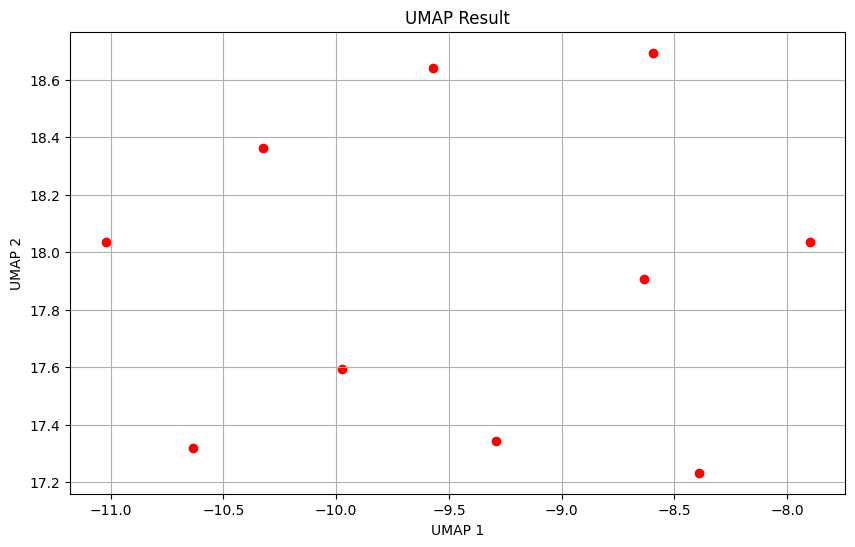

In [29]:
# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_data)

# Plot t-SNE result
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='green', marker='o')
plt.title('t-SNE Result')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()

# Run UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(scaled_data)

# Plot UMAP result
plt.figure(figsize=(10, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c='red', marker='o')
plt.title('UMAP Result')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()